### Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import imblearn
import pickle
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### Making few helper function that will be used later

In [2]:
# A function that will handle class imbalance

def handle_classimbalance(data):
    # Making two temporary separations
    X_temp = data.iloc[:,:-1]
    Y_temp = data.iloc[:,-1]
    #Applying SMOTE on the training data
    smote = imblearn.over_sampling.SMOTE(sampling_strategy=1.0, k_neighbors=5)
    X_temp, Y_temp = smote.fit_resample(X_temp, Y_temp)
    data = pd.concat([X_temp, Y_temp], axis=1)
    return data

In [3]:
# A custom function to remove outliers from the dataset
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
      
    global outlier_free_list
    global filtered_data
      
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

### Importing the dataset

In [4]:
# Importing training data
data = pd.read_excel("Case Study Data.xlsx")
print('There are total %s rows and %s columns in the dataset.' %(data.shape[0],data.shape[1]))

There are total 3331 rows and 14 columns in the dataset.


In [5]:
data.head()

,Sno,Customer_ID,Weeks,Contract_Renewal,Data_Plan,Data_Usage,Calls_To_Customer_Care,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Customer_Attrition,Inserted_Date
0,1,2951997.0,57.0,1.0,1.0,2.57,0.0,213.0,115.0,78.7,9.56,9.5,No,2012-05-01
1,2,2461448.0,54.0,1.0,0.0,0.00,3.0,134.3,73.0,37.0,7.78,14.7,No,2012-05-01
2,3,3573953.0,20.0,1.0,0.0,0.32,0.0,190.0,109.0,58.2,12.91,6.3,No,2012-05-01
3,4,728293.0,49.0,1.0,0.0,0.21,1.0,119.3,117.0,41.1,10.76,11.1,No,2012-05-01
4,5,6987894.0,142.0,1.0,0.0,0.00,2.0,84.8,95.0,27.0,6.84,14.2,No,2012-05-01


In [6]:
# Separating features based on nature either discrete or continuous  
continuous_feats = ['Weeks','Data_Usage','Calls_To_Customer_Care','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins']
discrete_feats = ['Contract_Renewal','Data_Plan','Customer_Attrition']

## 1. Understanding of Variables

**SNo** : It denotes the serial numbers of each row in the dataset.

**Customer_ID** : It denotes the unique id given to each customer.

**Weeks** : It denotes the number of weeks a customer has been using the network service provided by the company.

**Contract_Renewal** : It denotes if the person has renewed his/her contract or not. It has two values 0 and 1.
 - 0 means the person has not renewed the contract
 - 1 means the person has renewed the contract

**Data_Plan** : It denotes if the person has an active data plan or not. It has two values 0 and 1.
 - 0 means the person does not have an active data plan.
 - 1 means the person has an active data plan.

**Data_Usage** : It denotes the data usage of each customer.

**Calls_To_Customer_Care** : It denotes the number of calls made by a person to the customer care.

**DayMins** : It denotes the amount of minutes a person spends on a call in a day.

**DayCalls** : It denotes the total number of calls a person makes from his device in a day.

**MonthlyCharge** : It denotes the monthly charge incurred by the person.

**Overage Fee** : It is the charge imposed when the person goes beyond the allowed limit of calls.

**RoamMins** : It denotes the total number of minutes the call has been made from  the cell phone when it was in roaming.

**Customer_Attrition** : It denotes the loss of customer. It has two values Yes and No.
- Yes means the customer has been lost by the company.
- No denotes customer is currently using the service provided by the company.

- **Customer_Attrition is our target column in the dataset**

**Inserted_Date** : It denotes the date on which the sim card was inserted in the phone and made active for usage.
- The data given is of 1 May 2012 in the entire dataset

#### Checking the attributes and data type of each column in the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3331 entries, 0 to 3330
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Sno                     3331 non-null   int64         
 1   Customer_ID             3326 non-null   float64       
 2   Weeks                   3328 non-null   float64       
 3   Contract_Renewal        3322 non-null   float64       
 4   Data_Plan               3327 non-null   float64       
 5   Data_Usage              3330 non-null   float64       
 6   Calls_To_Customer_Care  3330 non-null   float64       
 7   DayMins                 3329 non-null   float64       
 8   DayCalls                3330 non-null   float64       
 9   MonthlyCharge           3329 non-null   float64       
 10  OverageFee              3330 non-null   float64       
 11  RoamMins                3330 non-null   float64       
 12  Customer_Attrition      3330 non-null   object  

**The dataset 1 datetime column, 11 float columns, 1 integer and 1 object column.**

In [8]:
# Printing some statistical information of the continuous features in the dataset
data[continuous_feats].describe()

,Weeks,Data_Usage,Calls_To_Customer_Care,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3328.000000,3330.000000,3330.000000,3329.000000,3330.000000,3329.000000,3330.000000,3330.000000
mean,101.060397,0.816495,1.563063,179.731481,100.428529,56.300721,10.051946,10.237027
std,39.845384,1.272796,1.315990,54.477605,20.076165,16.433952,2.535758,2.792802
min,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,74.000000,0.000000,1.000000,143.600000,87.000000,45.000000,8.330000,8.500000
50%,101.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,127.000000,1.780000,2.000000,216.300000,114.000000,66.200000,11.770000,12.100000
max,243.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


### Removal of irrelevant features

There are certain features in the dataset such as Sno, Customer_ID, Inserted_Date which might play no role in prediction of the customer attrition therefore we will drop these features from the dataset.

In [9]:
data.drop(['Sno','Customer_ID','Inserted_Date'],axis=1,inplace=True)

In [10]:
print('There are total %s rows and %s columns in the dataset after removing irrelevant features.'%(data.shape[0],data.shape[1]))

There are total 3331 rows and 11 columns in the dataset after removing irrelevant features.


## 2. Checking for null values inside the dataset and their treatment

In [11]:
data.isna().sum()

Weeks                     3
Contract_Renewal          9
Data_Plan                 4
Data_Usage                1
Calls_To_Customer_Care    1
DayMins                   2
DayCalls                  1
MonthlyCharge             2
OverageFee                1
RoamMins                  1
Customer_Attrition        1
dtype: int64

There are very few null values in each column. Since, the ratio of null values inside the dataset is very small as compared to total values in the dataset, we can drop these null values from the dataset, it will not result in any major data loss.

In [12]:
data.dropna(inplace=True)

In [13]:
print('There are total %s rows and %s columns in the dataset after removing missing values.'%(data.shape[0],data.shape[1]))

There are total 3315 rows and 11 columns in the dataset after removing missing values.


In [14]:
# Changing data type of discrete features from float to integers in 'Contract_Renewal' and'Data_Plan' feature**
data['Contract_Renewal'] = data['Contract_Renewal'].astype(int)
data['Data_Plan'] = data['Data_Plan'].astype(int)

#### Handling Class Imbalance

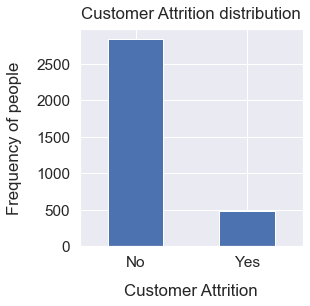

In [15]:
sns.set(font_scale=1.4)
data['Customer_Attrition'].value_counts().plot(kind='bar', figsize=(4,4), rot=0)
plt.xlabel("Customer Attrition", labelpad=14)
plt.ylabel("Frequency of people", labelpad=14)
plt.title("Customer Attrition distribution", y=1.02)
plt.show()

We can notice there is a data imbalance between both the classes so, it may lead to wrong predictions as our prediction model can become biased to one of the class and may give incorrect results. So, we will make use of SMOTE technique for oversampling the dataset.

In [16]:
# Making a call to the handle_classimbalance function
data = handle_classimbalance(data)
print('Shape of the dataset after oversampling is: ',data.shape)

Shape of the dataset after oversampling is:  (5670, 11)


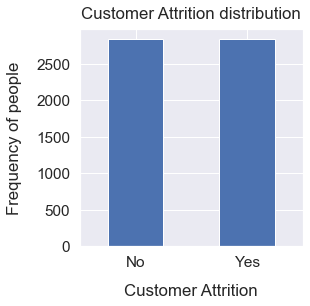

In [17]:
sns.set(font_scale=1.4)
data['Customer_Attrition'].value_counts().plot(kind='bar', figsize=(4, 4), rot=0)
plt.xlabel("Customer Attrition", labelpad=14)
plt.ylabel("Frequency of people", labelpad=14)
plt.title("Customer Attrition distribution", y=1.02)
plt.show()

#### Convering categorical feature into numerical feature

As we saw **Customer_Attrition** feature is our categorical variable and we can't process data in form of text, we need to convert it into a numerical variable. We will make use of the label encoder to convert encode categorical variables into numerical variables.

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [19]:
data['Customer_Attrition'] = le.fit_transform(data['Customer_Attrition'])

It maps 'No' values to 0 and 'Yes' values to 1

## 3. Data Exploration and Visualization

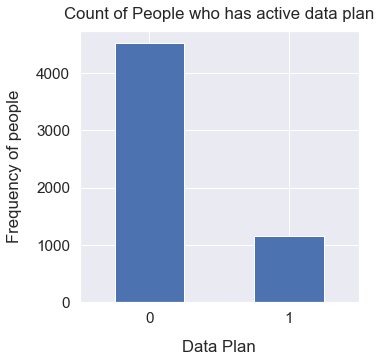

In [20]:
sns.set(font_scale=1.4)
data['Data_Plan'].value_counts().plot(kind='bar', figsize=(5, 5), rot=0)
plt.xlabel("Data Plan", labelpad=14)
plt.ylabel("Frequency of people", labelpad=14)
plt.title("Count of People who has active data plan", y=1.02)
plt.show()

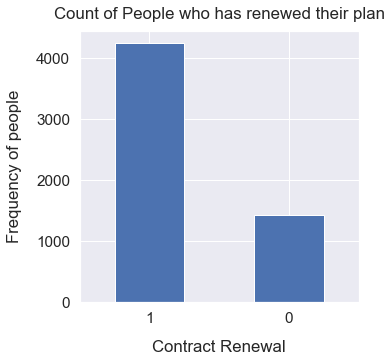

In [21]:
sns.set(font_scale=1.4)
data['Contract_Renewal'].value_counts().plot(kind='bar', figsize=(5, 5), rot=0)
plt.xlabel("Contract Renewal", labelpad=14)
plt.ylabel("Frequency of people", labelpad=14)
plt.title("Count of People who has renewed their plan", y=1.02)
plt.show()

### Univariate Analysis of features in the dataset

#### (a) Plotting a histogram for continuous features

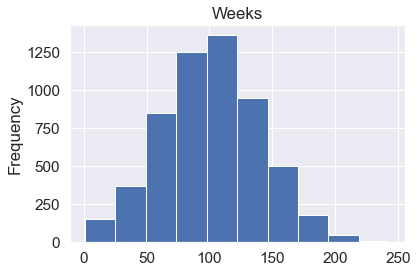

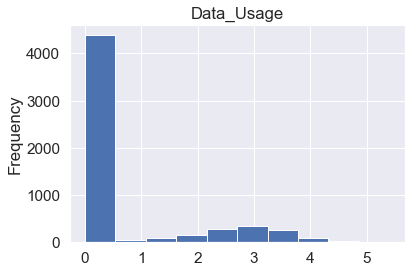

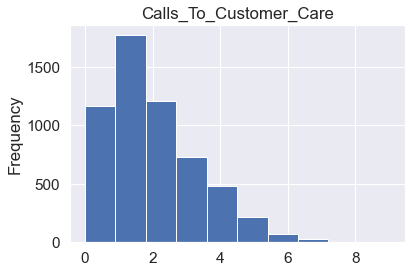

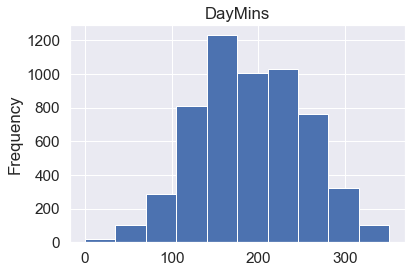

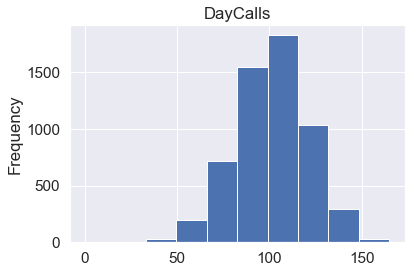

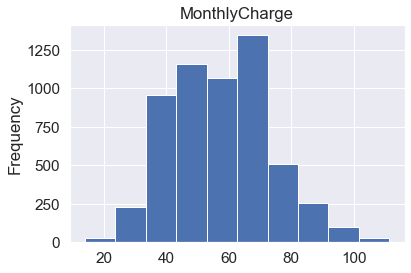

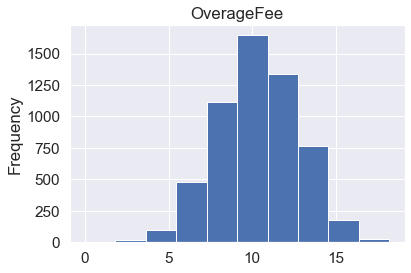

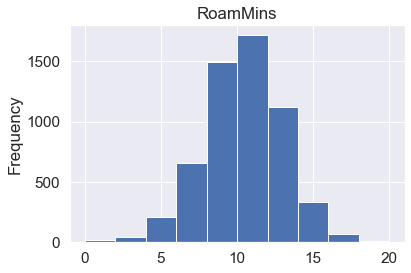

In [22]:
for i in continuous_feats:
    plt.title(i)
    data[i].plot(kind='hist')
    plt.show()

#### (b) Plotting a box plot for continuous features

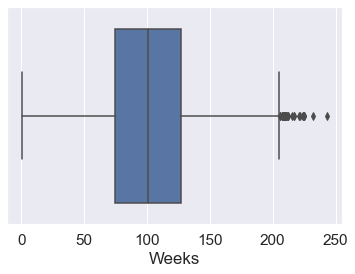

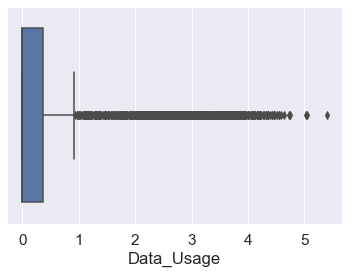

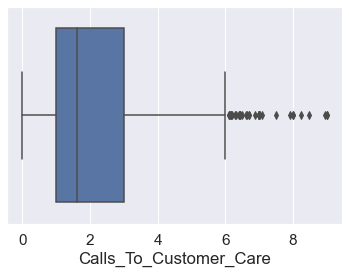

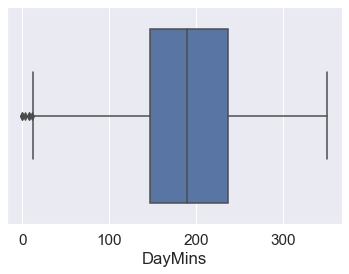

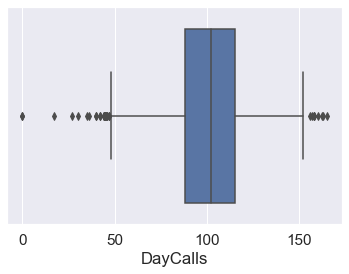

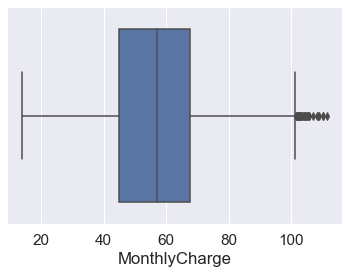

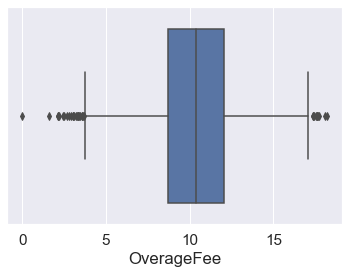

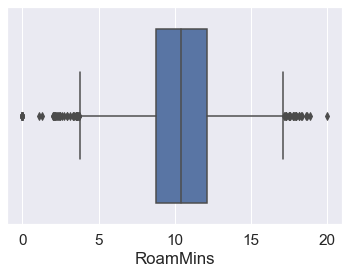

In [23]:
for i in continuous_feats:
    sns.boxplot(data[i])
    plt.show()

**Conclusions from univariate analysis**

- Continuous features such as Weeks, DayMins,DayCalls, MonthlyCharge, OverageFee, RoamMins seems to be uniformly distributed.
- Data Usage column has values where a lot of people have no data usage, so it should be kept in mind while we will check for outlier removal. Otherwise, it will take other values than zero as outliers.
- Calls_To_Customer_Care and Data_Usage feature is positively skewed.
- The box plot shows there are some **outliers** in the dataset, we will remove these outliers in the feature engineering phase. Also, as we saw earlier **'Data_Usage'** feature has majority 0 values which treats other values as outliers so, it is not right, we will keep them during outlier removal. 

In [24]:
# Removing the skewness in Data_Usage feature by applying cube root transformations
data['Data_Usage'] = np.cbrt(data['Data_Usage'])

In [25]:
# Removing the outliers
for i in continuous_feats:
    if i == 'Data_Usage':
        continue
    else:
        data = removeOutliers(data, i)
print("Shape of data after outlier removal is: ", data.shape)

Shape of data after outlier removal is:  (5390, 11)


### Bivariate analysis of the features of dataset

#### (a)  Drawing a pairplot

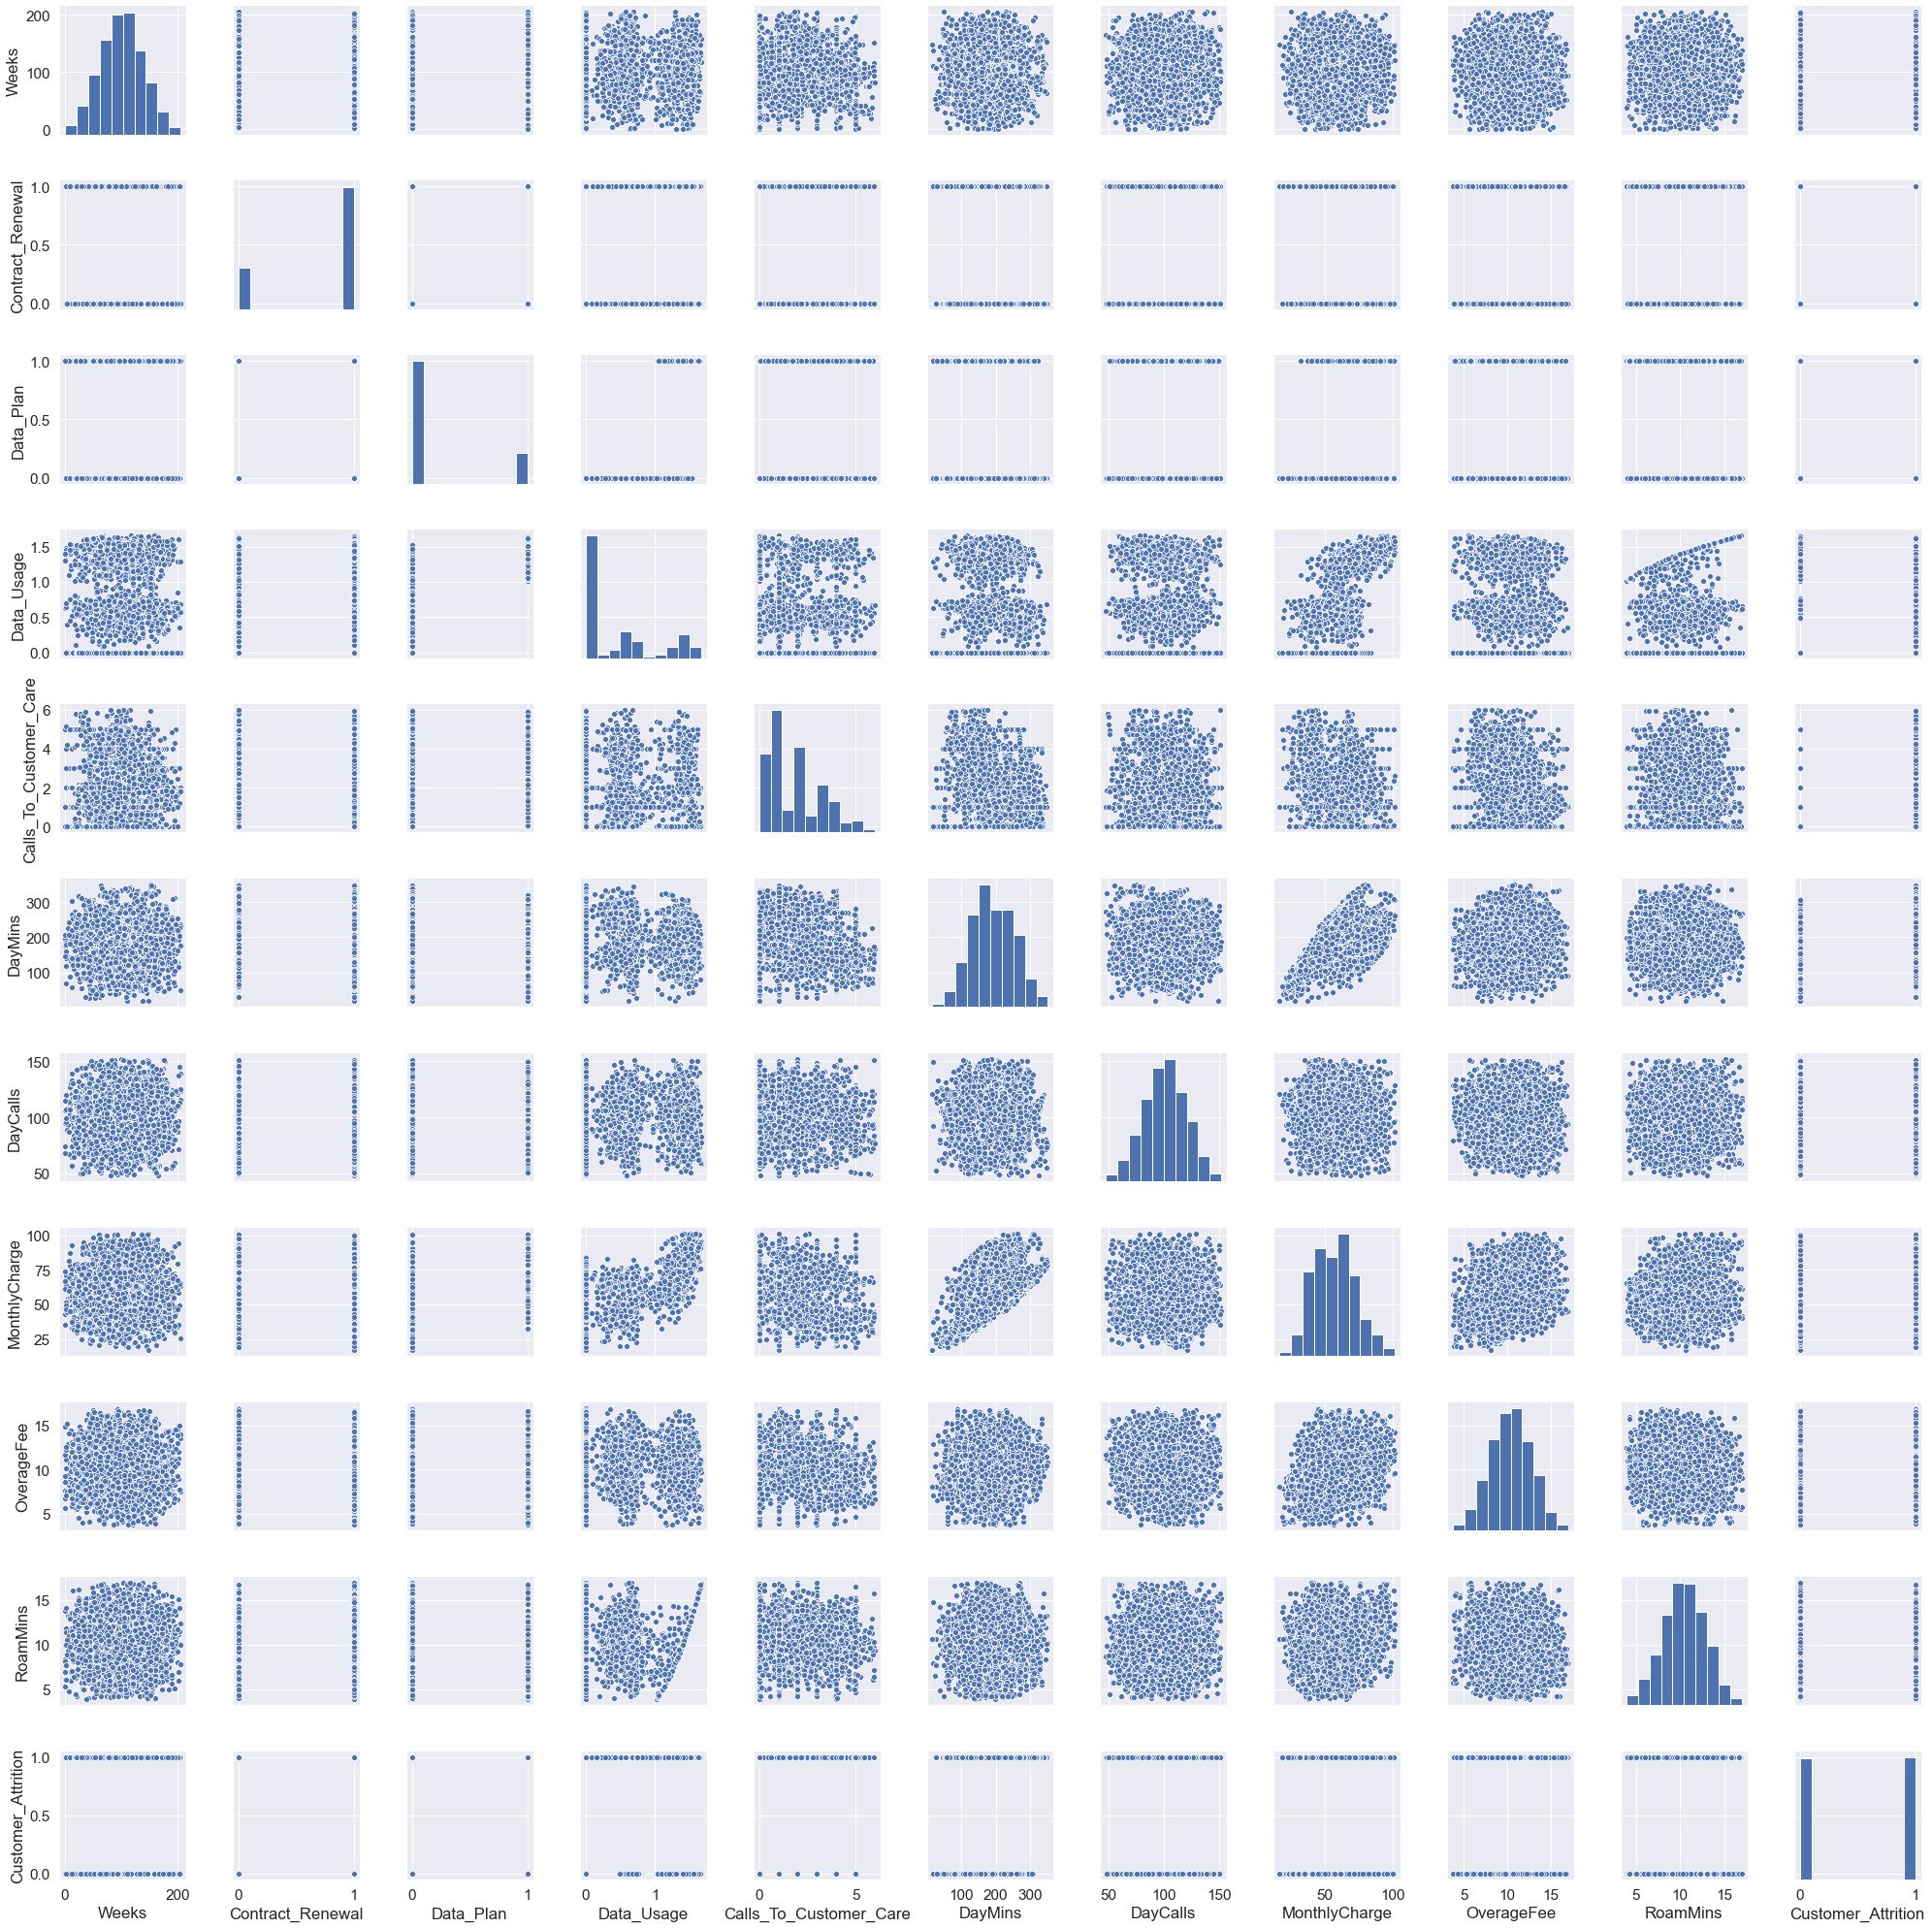

In [26]:
sns.pairplot(data)
plt.show()

#### (b) Plotting a correlation heatmap

Since, it is clear that **Customer_Attrition** feature is our target column in the dataset, we will plot a correlation plot/heatmap to see correlation of other features with our target column.

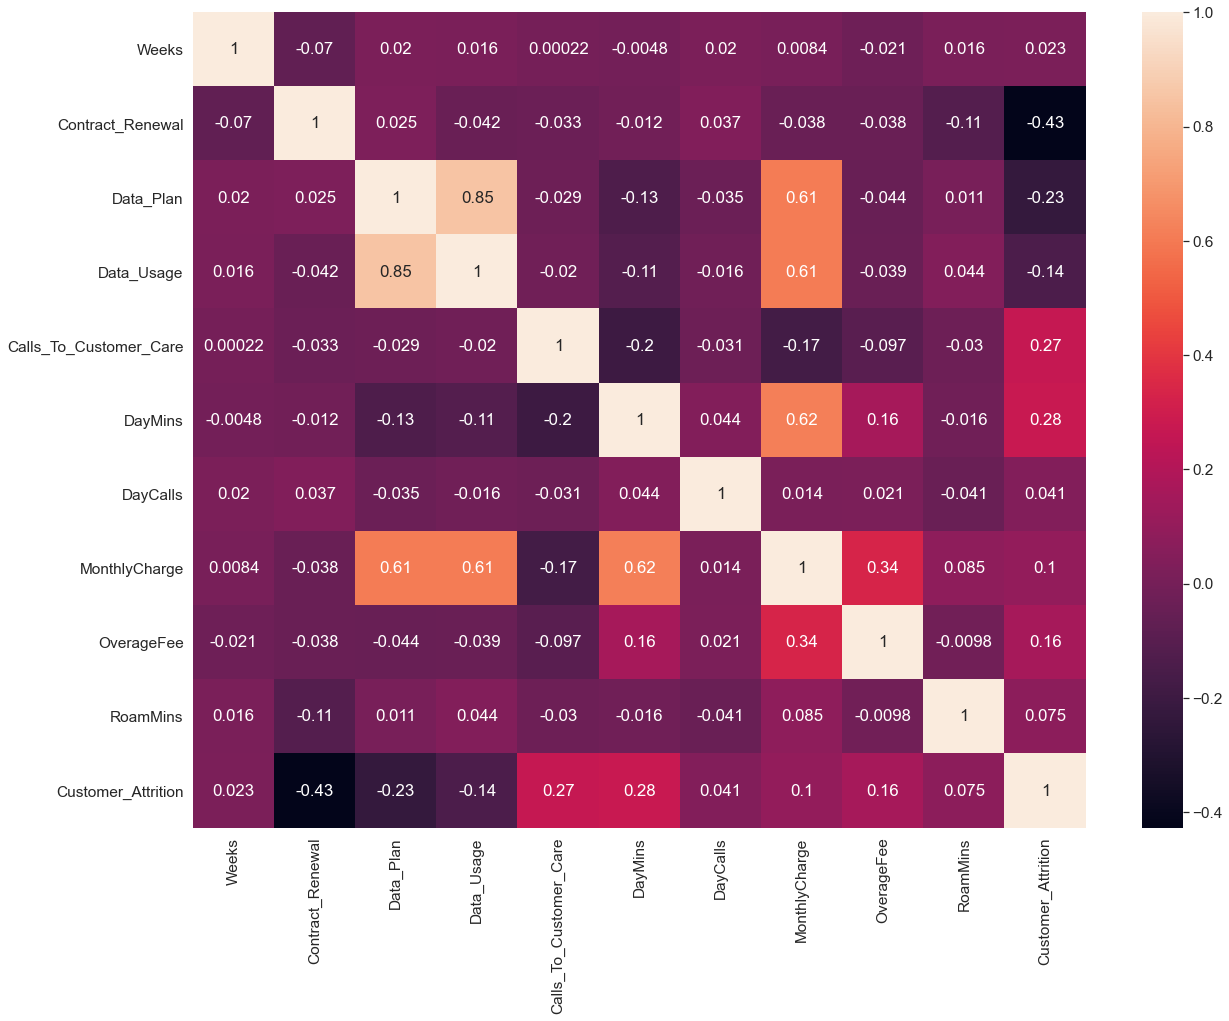

In [27]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

**Conclusions from the heatmap:**
- Calls_To_Customer_Care feature and DayMins feature has highest positive correlation with our target feature i.e., Customer_Attrition.
- Contract_Renewal feature has highest negative correlation with our target feature i.e., Customer_Attrition. It means the person who has made their service plan renewal are more likely to stay on the same network.
- Data_Usage and Data_Plan are highly positively correlated which is obvious as those person who has data plan will be having high data usage.
- Data_Usage and MonthlyCharge are highly positively correlated which is obvious as those person who has high data usage will be having high monthly charge and who uses less data will have less monthly charge.
- Data_Plan and MonthlyCharge are highly positively correlated which is true, the person who will have data plan will have more monthly charge as compared to others.
- DayMins is also very positively correlated with MonthlyCharge, it is also true as the person who will talk more minutes on the call will have much greater bill.
- OverageFee also posseses positive correlation with MonthlyCharge which is True, the person who crosses allowed plan will be charged extra. Hence, his monthly charge increases.


#### Plotting a correlation score bar plot

In [28]:
dataset_corr = data.corr()
df_corr = dataset_corr.iloc[:,-1]
feature_names = df_corr.sort_values(ascending=False).index.values
features_names = feature_names[1:]
feature_scores = df_corr.sort_values(ascending=False).values
feature_scores = feature_scores[1:]

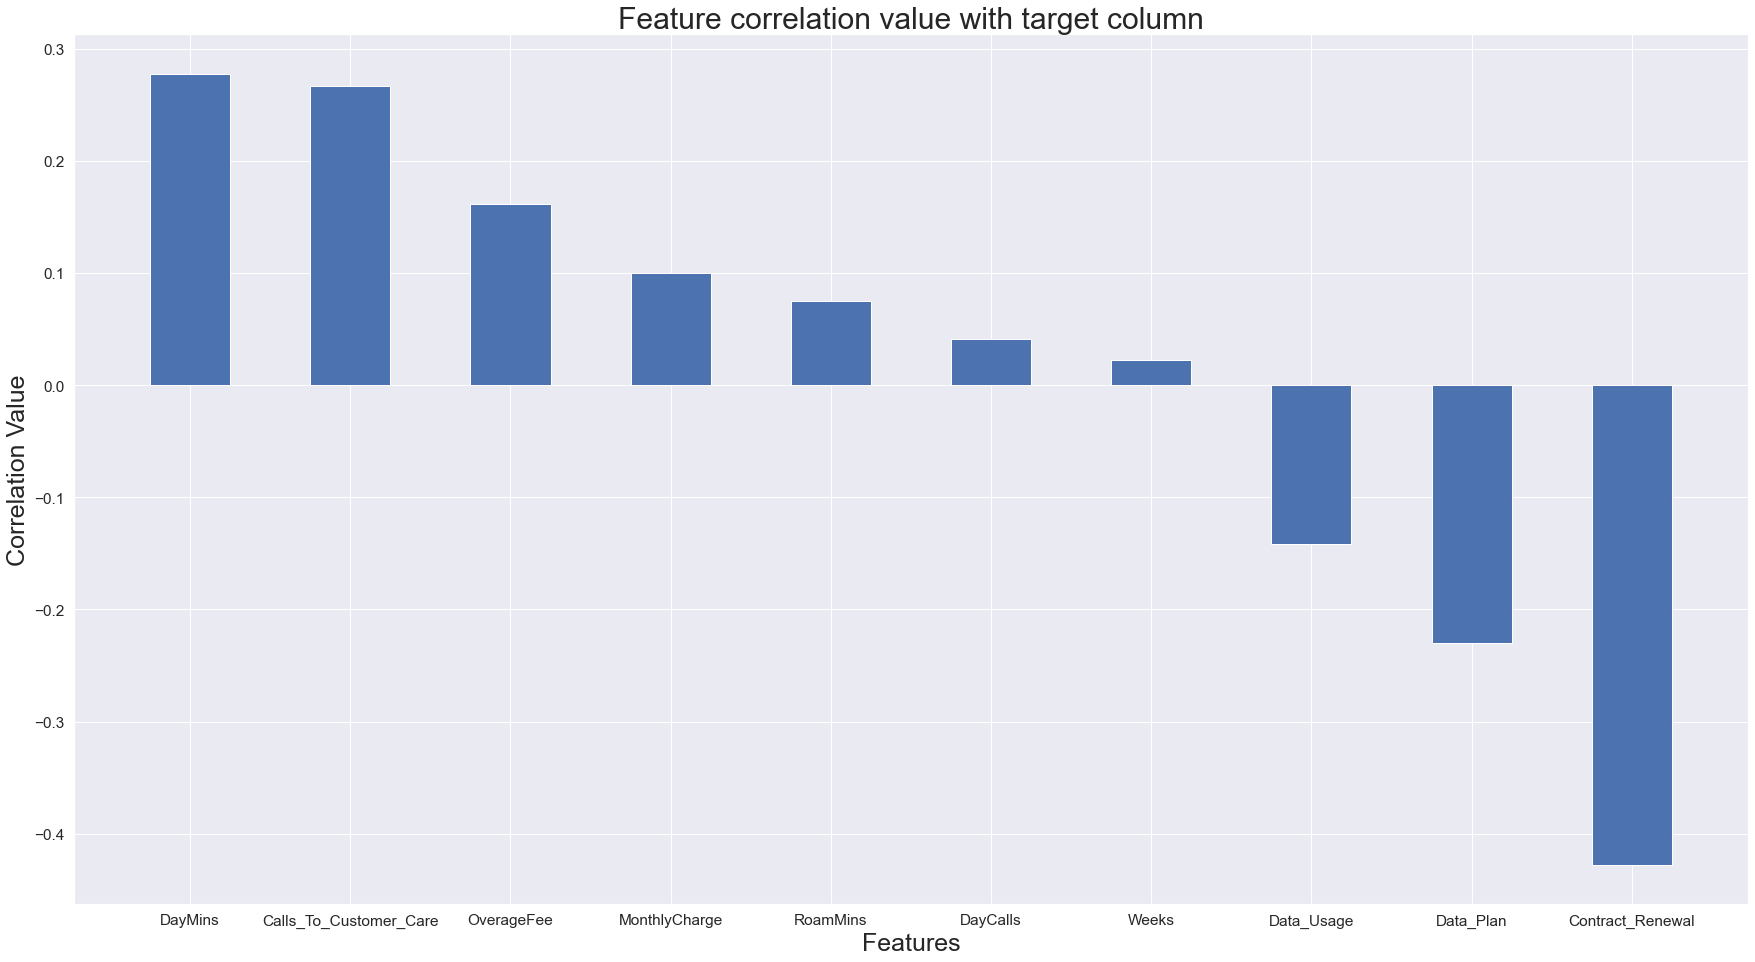

In [29]:
plt.figure(figsize=(30,16))
plt.bar(features_names,feature_scores,width=0.5)
plt.title('Feature correlation value with target column',fontdict={'fontsize':30})
plt.xlabel("Features",fontdict={'fontsize':25})
plt.ylabel("Correlation Value",fontdict={'fontsize':25})
plt.show()

### 4. Feature Engineering

(a) One of the task we already performed is encoding of our Target column using Label Encoder

(b) We already performed oversampling to balance the classes present in our target column.

(c) Removed outliers from the dataset using the IQR method

(d) Applied cube root transformation on features to remove skewness from the dataset

### Dividing the dataset into separate groups

#### Dividing data into dependent (feature) and independent (target) sets

In [30]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

#### Dividing data for training and validation

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train,X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.25,random_state=42)

### 5. Model Building, Evaluation and Interpretation

### 5.1 Model Building

#### (A) Building a Logistic Regression model

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [34]:
lr.fit(X_train,Y_train)

LogisticRegression()

In [35]:
print('Score of model on validation data is: ', lr.score(X_val,Y_val))
print('ROC_AUC score of Logistic Regression model is: %.3f'%(roc_auc_score(Y_val, lr.predict(X_val), average=None)*100))

Score of model on validation data is:  0.7900593471810089
ROC_AUC score of Logistic Regression model is: 79.010


[[552 121]
 [162 513]]


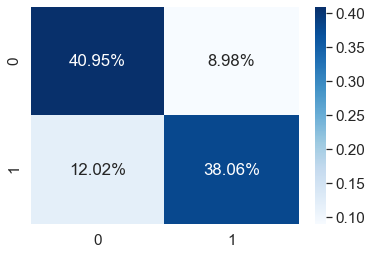

In [36]:
cf_matrix = confusion_matrix(Y_val, lr.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (B) Building a Random Forest Classifier model

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)

RandomForestClassifier()

In [38]:
print('Score of model on validation data is: ', rf.score(X_val,Y_val))
print('ROC_AUC score of Random Forest Classifier model is: %.3f'%(roc_auc_score(Y_val, rf.predict(X_val), average=None)*100))

Score of model on validation data is:  0.9384272997032641
ROC_AUC score of Random Forest Classifier model is: 93.843


[[635  38]
 [ 45 630]]


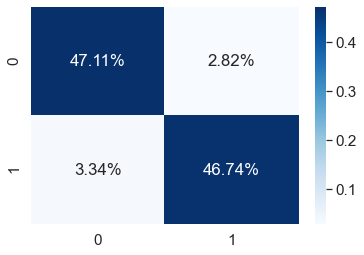

In [39]:
cf_matrix = confusion_matrix(Y_val, rf.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (C) Building a ExtraTreesClassifier model

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_train,Y_train)

ExtraTreesClassifier()

In [41]:
print('Score of model on validation data is: ', etc.score(X_val,Y_val))
print('ROC_AUC score of Extra Trees Classifier model is: %.3f'%(roc_auc_score(Y_val, etc.predict(X_val), average=None)*100))

Score of model on validation data is:  0.9406528189910979
ROC_AUC score of Extra Trees Classifier model is: 94.065


[[630  43]
 [ 37 638]]


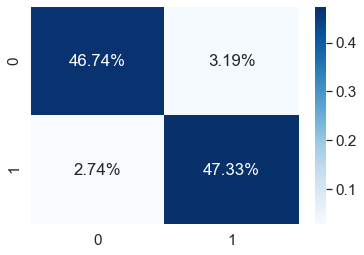

In [42]:
cf_matrix = confusion_matrix(Y_val, etc.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (D) Building a XGBoost Classifier Model

In [43]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xg_model = xgb.fit(X_train,Y_train)

[13:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
print('Score of model on validation data is: ', xg_model.score(X_val,Y_val))
print('ROC_AUC score of XGBoost Classifier model is: %.3f'%(roc_auc_score(Y_val, xg_model.predict(X_val), average=None)*100))

Score of model on validation data is:  0.9547477744807121
ROC_AUC score of XGBoost Classifier model is: 95.476


[[647  26]
 [ 35 640]]


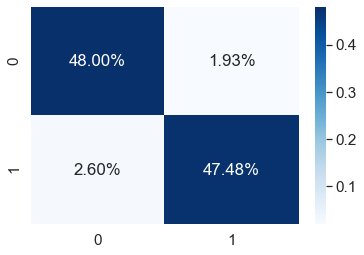

In [45]:
cf_matrix = confusion_matrix(Y_val, xgb.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (E) Building a CatBoost classification model

In [46]:
from catboost import CatBoostClassifier

In [47]:
cbc = CatBoostClassifier(silent=True)
cbc.fit(X_train,Y_train)

In [48]:
print('Score of model on validation data is: ', cbc.score(X_val,Y_val))
print('ROC_AUC score of Cat Boost Classifier model is: %.3f'%(roc_auc_score(Y_val, cbc.predict(X_val), average=None)*100))

Score of model on validation data is:  0.951780415430267
ROC_AUC score of Cat Boost Classifier model is: 95.178


[[641  32]
 [ 33 642]]


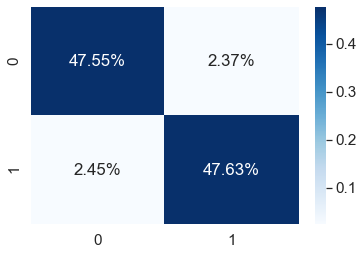

In [49]:
cf_matrix = confusion_matrix(Y_val, cbc.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (F) Building a Gradient Boosting Classifier model

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train,Y_train)

GradientBoostingClassifier()

In [51]:
print('Score of model on validation data is: ', gbc.score(X_val,Y_val))
print('ROC_AUC score of Gradient Boosting Classifier model is: %.3f'%(roc_auc_score(Y_val, gbc.predict(X_val), average=None)*100))

Score of model on validation data is:  0.9443620178041543
ROC_AUC score of Gradient Boosting Classifier model is: 94.436


[[636  37]
 [ 38 637]]


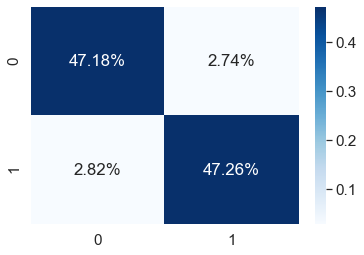

In [52]:
cf_matrix = confusion_matrix(Y_val, gbc.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

#### (G) Buildng a Stacked Classifier

In [53]:
from mlxtend.classifier import StackingCVClassifier
stk_classifier = StackingCVClassifier(classifiers=(gbc,rf,xgb,etc,cbc),meta_classifier=xgb,
                                      use_features_in_secondary=True,store_train_meta_features=True,random_state=42)
stacked_model = stk_classifier.fit(X_train,Y_train)

[13:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
print('Score of stacked model on validation data is: ', stacked_model.score(X_val,Y_val))
print('ROC_AUC score of Stacked Classifier model is: %.3f'%(roc_auc_score(Y_val, stacked_model.predict(X_val), average=None)*100))

Score of stacked model on validation data is:  0.956973293768546
ROC_AUC score of Stacked Classifier model is: 95.698


[[648  25]
 [ 33 642]]


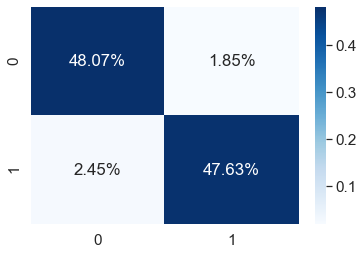

In [55]:
cf_matrix = confusion_matrix(Y_val, stacked_model.predict(X_val))
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

### 5.2 Model Evaluation and Interpretation

The ROC_AUC score of our models in decreasing order is:
1. Stacked Classifier : 95.698
2. Cat Boost Classifier : 95.178
3. XGBoost Classifier : 95.476
4. Gradient Boosting Classifier : 94.436
5. Extra Trees Classifier : 94.065
6. Random Forest Classifier : 93.843
7. Logistic Regression : 79.010

**Note:** We have made use of only the default hyperparameters for each classifier, if we perform hyperparametertuning for our models it is possible that it may lead to further improved accuracy of our model.

Few of our model perform quite well in predicting the Customer Attrition and can be used by the company to prevent happening of such cases in the future and helps the company to identify loose ends and provide better service to their customers.

### 6. What's next?

**A. Discussing the problem with the team.**

We did not only find out which customers are likely to churn, but also which features have the most impact on a customer leaving.

- 'Calls_To_Customer_Care' is one major reason, may be a person calls the customer care occassionly because of any issue and his/her issue does not get resolved.

- 'DayMins; is one feature that suggests people who are spending more minutes on the call are leave, it may be due to any technical difficulties or maybe due to personal reasons.

- 'OverageFee' is yet another feature, which has high contribution to churning, may be the charges are too much high.

So, we can discuss on these factors with the team and look around for loopholes and work on these to reduce the chances of churning.

**B. Taking feedbacks from the customers.**

We can engage with our customers and ask them about the issues they are facing with our service. Take their feedback and regularly and work on it to improves our services.

In [56]:
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(stacked_model, file)